In [ ]:
#ДЗ
# 1. Для изображения sar_3.jpg найти наиболее протяженный участок
# (выделить линии при помощи преобразования Хафа)
# 2. Для изображения sar_3.jpg провести исследование алгоритмов бинаризации, выделить участок дорожной полосы.

## 1. Импорты и загрузка

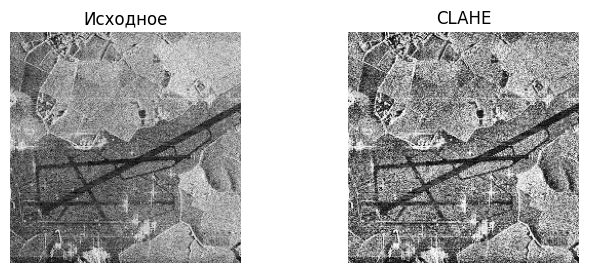

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

IMG = 'sar_3.jpg'
img = cv2.imread(IMG, cv2.IMREAD_GRAYSCALE)
assert img is not None, "Положи sar_3.jpg рядом с ноутбуком"

# чуть выравниваем контраст для SAR
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_eq = clahe.apply(img)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.imshow(img, cmap='gray'); plt.title('Исходное'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(img_eq, cmap='gray'); plt.title('CLAHE'); plt.axis('off')
plt.show()


## 2. Лёгкая нормализация контраста (CLAHE)

Самая длинная линия: длина = 315.4 пикс, угол = 45.0°


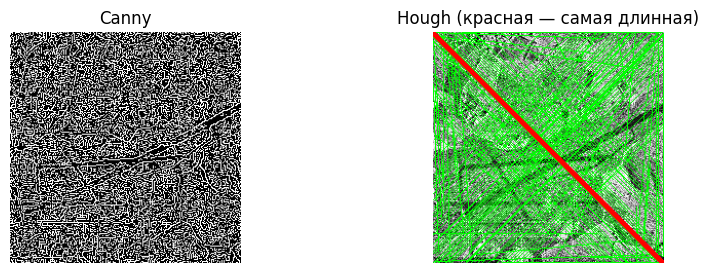

In [21]:
# границы
edges = cv2.Canny(img_eq, 60, 150, L2gradient=True)

# вероятностный Хафф: параметры можно подстроить
lines = cv2.HoughLinesP(edges,
                        rho=1,
                        theta=np.pi/180,
                        threshold=60,       # кол-во голосов
                        minLineLength=40,   # минимальная длина
                        maxLineGap=8)       # разрыв между сегментами

longest = None
max_len = -1.0

if lines is not None:
    for (x1,y1,x2,y2) in lines[:,0]:
        L = np.hypot(x2-x1, y2-y1)
        if L > max_len:
            max_len = L
            longest = (x1,y1,x2,y2)

vis = cv2.cvtColor(img_eq, cv2.COLOR_GRAY2BGR)
if lines is not None:
    # нарисуем все линии тонко
    for (x1,y1,x2,y2) in lines[:,0]:
        cv2.line(vis, (x1,y1), (x2,y2), (0,255,0), 1)

# и жирно — самую длинную
if longest is not None:
    x1,y1,x2,y2 = longest
    cv2.line(vis, (x1,y1), (x2,y2), (0,0,255), 3)

    # характеристики
    length_px = max_len
    angle_deg = np.degrees(np.arctan2(y2-y1, x2-x1))  # [-180,180]

    print(f"Самая длинная линия: длина = {length_px:.1f} пикс, угол = {angle_deg:.1f}°")
else:
    print("Линии не найдены. Подстрой параметры Canny/Хафф.")

plt.figure(figsize=(10,3))
plt.subplot(1,2,1); plt.imshow(edges, cmap='gray'); plt.title('Canny'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(vis[...,::-1]); plt.title('Hough (красная — самая длинная)'); plt.axis('off')
plt.show()


## 3.Масштабирование, поворот, сдвиг

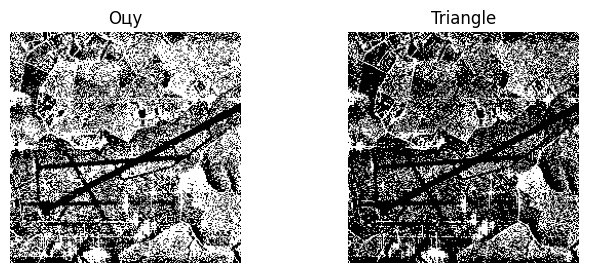

In [22]:
# Оцу
_, th_otsu = cv2.threshold(img_eq, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
# Треугольник (если контур гистограммы одногорбый — часто для SAR)
_, th_tri  = cv2.threshold(img_eq, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_TRIANGLE)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.imshow(th_otsu, cmap='gray'); plt.title('Оцу'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(th_tri,  cmap='gray'); plt.title('Triangle'); plt.axis('off')
plt.show()


## 4. Аффин и перспектива (четыре угла ВПП)

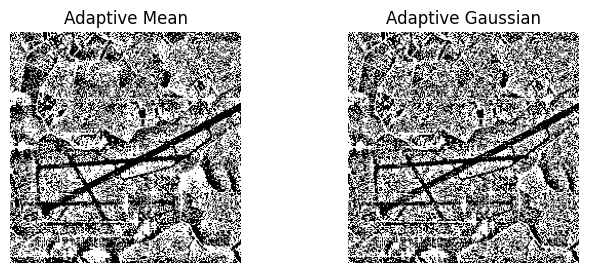

In [24]:
adp_mean = cv2.adaptiveThreshold(img_eq, 255,
                                 cv2.ADAPTIVE_THRESH_MEAN_C,
                                 cv2.THRESH_BINARY,
                                 blockSize=31, C=5)

adp_gau  = cv2.adaptiveThreshold(img_eq, 255,
                                 cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                 cv2.THRESH_BINARY,
                                 blockSize=31, C=5)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.imshow(adp_mean, cmap='gray'); plt.title('Adaptive Mean'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(adp_gau,  cmap='gray'); plt.title('Adaptive Gaussian'); plt.axis('off')
plt.show()


## 5. Canny + вероятностный Хафф (прямые)

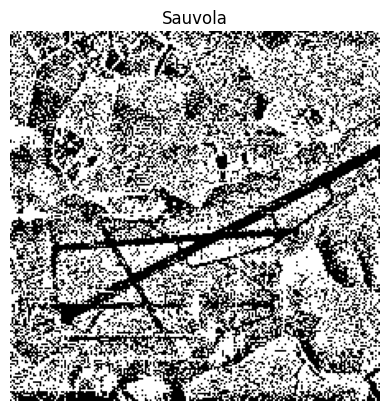

In [25]:
try:
    from skimage.filters import threshold_sauvola
    T = threshold_sauvola(img_eq, window_size=33, k=0.2)
    sauvola = (img_eq > T).astype(np.uint8)*255
    has_sauvola = True
except Exception:
    sauvola = None
    has_sauvola = False

if has_sauvola:
    plt.imshow(sauvola, cmap='gray'); plt.title('Sauvola'); plt.axis('off'); plt.show()
else:
    print("Sauvola недоступен (нет scikit-image) — пропускаем.")


## 6. Ключевые точки ORB

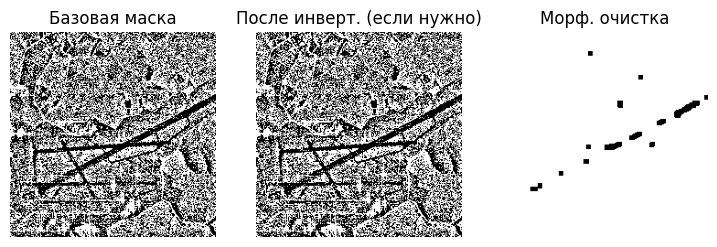

In [26]:
# выбери одну маску как базовую:
mask_base = adp_gau  # попробуй поменять на th_tri или th_otsu при необходимости

# инвертировать/не инвертировать в зависимости от того, чем заполнена полоса
# посмотрим долю белого:
white_ratio = mask_base.mean()/255
# если белого слишком много/мало — можно инвертнуть
mask = mask_base.copy()
if white_ratio < 0.3:
    # возможно, полоса стала чёрной — инвертнём
    mask = cv2.bitwise_not(mask)

# морфология: закрытие, чтобы собрать разрывы; потом открытие, чтобы убрать мелочь
kernel = np.ones((3,3), np.uint8)
mask_clean = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
mask_clean = cv2.morphologyEx(mask_clean, cv2.MORPH_OPEN,  kernel, iterations=1)

plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(mask_base,  cmap='gray'); plt.title('Базовая маска'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(mask,       cmap='gray'); plt.title('После инверт. (если нужно)'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(mask_clean, cmap='gray'); plt.title('Морф. очистка'); plt.axis('off')
plt.show()


## 7. Соответствия между исходным и повёрнутым/масштабированным

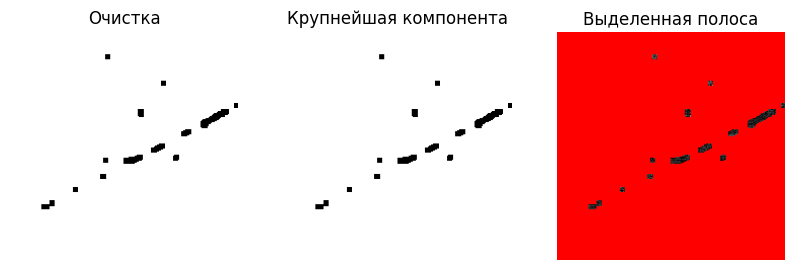

In [27]:
# connected components
num, labels = cv2.connectedComponents(mask_clean)
areas = [(labels==i).sum() for i in range(1, num)]
if areas:
    best_idx = 1 + int(np.argmax(areas))
    runway_mask = (labels==best_idx).astype(np.uint8)*255
else:
    runway_mask = mask_clean  # если что-то пошло не так — оставим как есть

# наложим на изображение
runway_vis = cv2.cvtColor(img_eq, cv2.COLOR_GRAY2BGR)
runway_vis[runway_mask==255] = (0,0,255)  # подсветка красным

plt.figure(figsize=(10,3))
plt.subplot(1,3,1); plt.imshow(mask_clean, cmap='gray'); plt.title('Очистка'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(runway_mask, cmap='gray'); plt.title('Крупнейшая компонента'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(runway_vis[...,::-1]); plt.title('Выделенная полоса'); plt.axis('off')
plt.show()


## 8. Оценка гомографии и «выпрямление» обратно

Инлайеров: 100 из 100


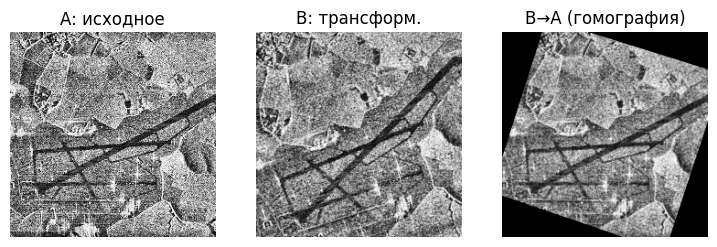

In [18]:
good = matches[:100]
ptsA = np.float32([kpsA[m.queryIdx].pt for m in good]).reshape(-1,1,2)
ptsB = np.float32([kpsB[m.trainIdx].pt for m in good]).reshape(-1,1,2)

H_est, mask = cv2.findHomography(ptsB, ptsA, cv2.RANSAC, 3.0)
print("Инлайеров:", int(mask.sum()), "из", len(good))

restored = cv2.warpPerspective(img_b, H_est, (w, h))
plt.figure(figsize=(9,3))
plt.subplot(1,3,1); plt.imshow(img_eq, cmap='gray'); plt.title('A: исходное'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(img_b, cmap='gray'); plt.title('B: трансформ.'); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(restored, cmap='gray'); plt.title('B→A (гомография)'); plt.axis('off')
plt.show()


## 9. Shi–Tomasi (Good Features to Track)

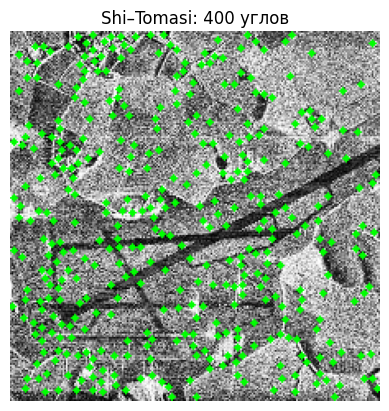

In [19]:
corners = cv2.goodFeaturesToTrack(img_eq, maxCorners=400, qualityLevel=0.01, minDistance=5)
corners = corners.astype(int).reshape(-1,2)
visc = cv2.cvtColor(img_eq, cv2.COLOR_GRAY2BGR)
for x,y in corners: cv2.circle(visc, (x,y), 2, (0,255,0), -1)

plt.imshow(visc[...,::-1]); plt.title(f'Shi–Tomasi: {len(corners)} углов'); plt.axis('off'); plt.show()
